# SLU18 - Unsupervised Learning: Learning notebook

In this notebook we will cover the following: 

    - Clustering
    - K-means
    - Dimensionality reduction

Some quick imports to get us started:

In [1]:
import pandas as pd 
import numpy as np

# Import the classifier we will be using
from sklearn.ensemble import RandomForestClassifier

# Import train/test split function
from sklearn.model_selection import train_test_split

# Some quick utilts to avoid filling this notebook with support code 
from utils import get_data_wine, plot_pair_plots, compute_distances, plot_density_chlorides, plot_kmeans_density_chlorides, plot_toy_dataset, plot_elbow_method, plot_kmeans, plot_cumulative_explained_variance_ratio, get_wine_quality, plot_two_dimensions

% matplotlib inline

# A Quick Introduction

So, up to this point you always had a target variable to predict and to evaluate your models. That's cute.

<img src="https://i.imgflip.com/28tchm.jpg" style="width: 400px;"/>

And then you go

<img src="https://78.media.tumblr.com/38cb194500a45e930f79e7ec83a3c91d/tumblr_ntaglrvavg1ucxtamo3_400.gif" style="width: 400px;"/>

You probably got the idea, but consider this question example. Imagine that you're a data scientist working on a company and you are asked the following:

>_Do our customers naturally fall into different groups?_

Here no specific purpose or target has been specified for the grouping. When there is no such target, the problem is referred to as unsupervised. A great metaphor to distinguish a supervised from an unsupervised problem is the following:

>_A teacher "supervises" the learner by carefully providing target information along with a set of examples. An unsupervised learning task might involve the same set of examples but would not include the target information. The learner would be given no information about the purpose of the learning, but would be left to form its own conclusions about what the examples have in common._

An unsupervised task is also commonly called as **Clustering**, because they consist on producing groupings based on similarities. However, there is no guarantee that these similarities are meaningful or will be useful for any particular purpose.

For this notebook, we will use a classical dataset of red variants of the Portuguese Vinho Verde wine, from the north of Portugal:

In [2]:
data = get_data_wine()
print(data.shape)
data.head()

(1599, 11)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


The data set contains information about 1599 different wine samples. The variable names are self explanatory, as you can see above.

Before we go any further, let's get a visual intuition of our data.

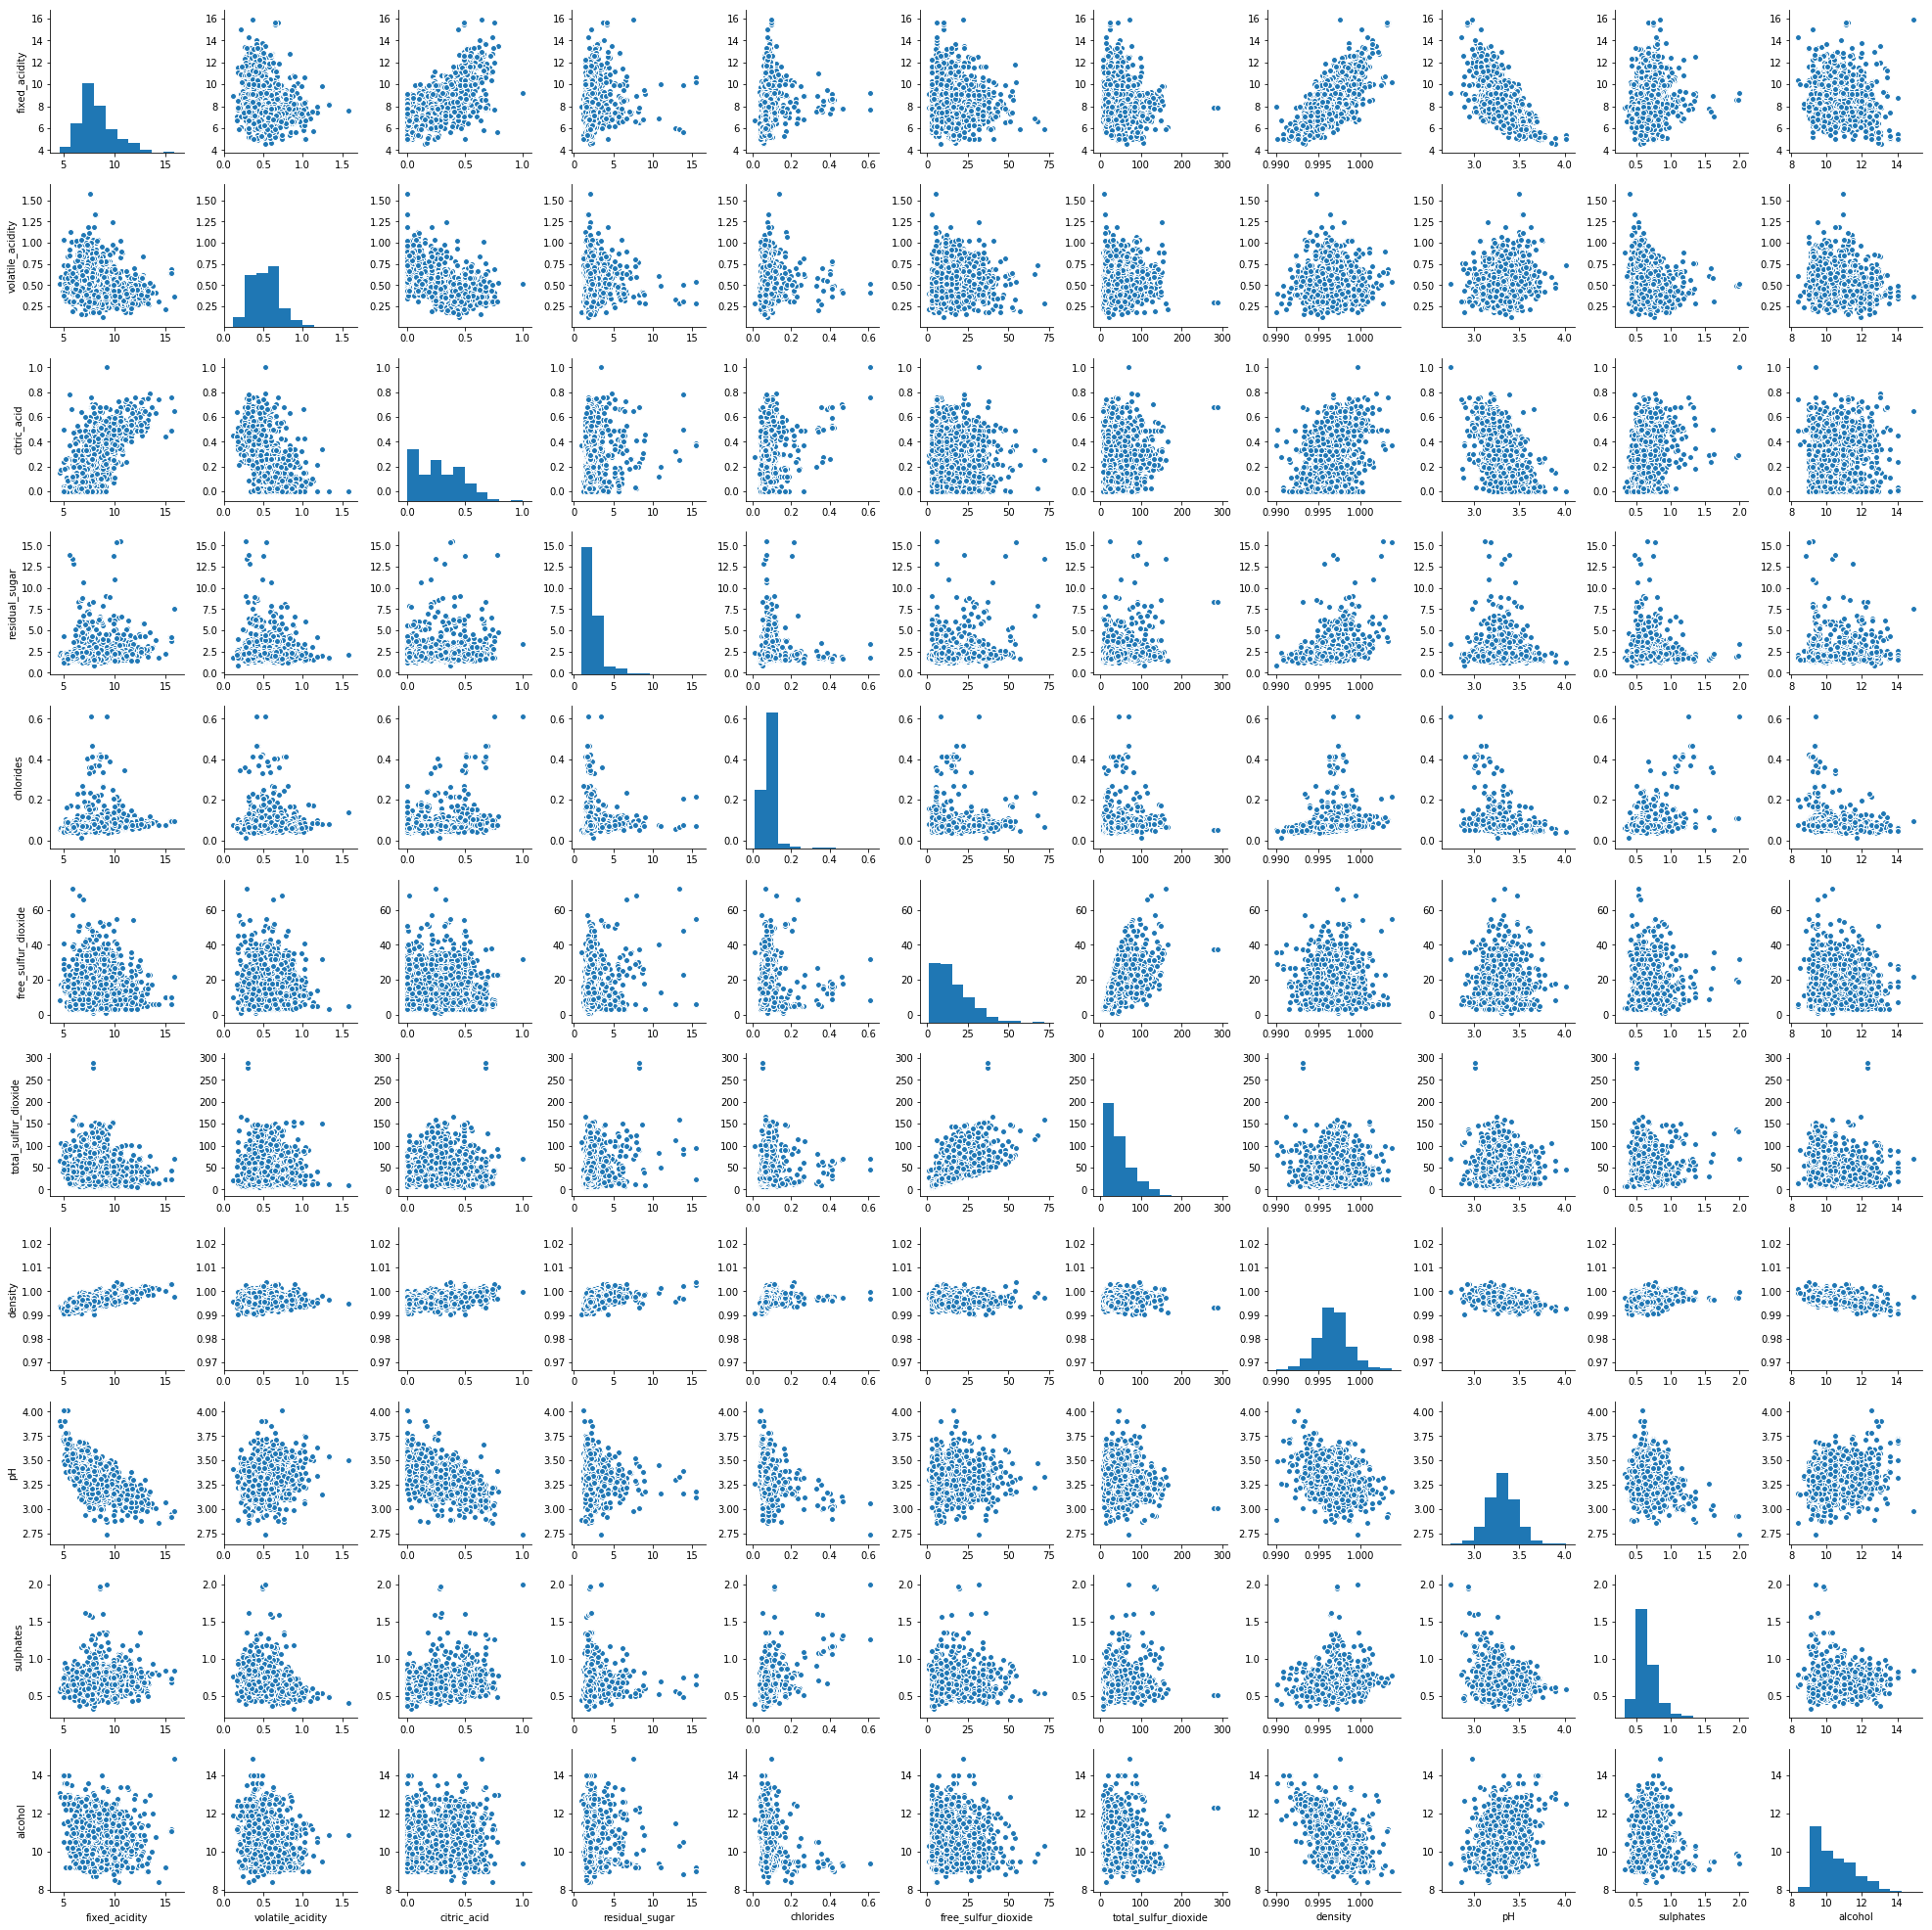

In [3]:
plot_pair_plots(data)

**Note:** you can double click on the image to zoom it further.

Basically, we made a plot for each pairwise feature relationship. As you can see, it is actually very important and useful to look at data visualizations in unsupervised tasks. We can by visual inspection easily see the outliers in each plot and perhaps some possible clusters.

# Clustering

So, we've seen that Clustering is an unsupervised task which consists of finding groups of data observations (such as wine samples, consumers, businesses...), where the data observations within groups are similar, but the data observations in different groups are not so similar. But how can we obtain the similarity between them?

### Similarity and Distance

Now that we have a dataset and a clustering task, we can start thinking about the similarity between wine samples, or alternatively the distances between wine samples. We can consider each wine sample in the data set as a feature vector:

In [4]:
example = data.loc[:4].copy()
example

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


Thus, the closer two wine samples are in the space defined by the features, the more similar they are! We can see that the wine samples above have multiple features. How can we measure the similarity or distance between, let's say, wine sample 0 from the wine samples 1 to 4? There are many different ways to do so, but let's begin with basic geometry.

### Euclidean Distance

For simplicity, let's assume that we have two wine samples A and B with only two numerical features. Thus, we can represent each wine sample in a two-dimensional space.

<img src="media/euclidean_distance.png" style="width: 400px;"/>

We can see that point A and B have coordinates $(X_A,Y_A)$ and $(X_B,Y_B)$, respectively. From here we can draw a triangle and use the good old Pythagorean theorem to obtain the distance between $\mathbf{A}$ and $\mathbf{B}$. As a reminder, the Pythagorean theorem tells us that the distance between A and B is given by the length of the hypotenuse, and is equal to the square root of the summed squares of the lengths of the other two sides of the triangle which can be simplified in this expression.

$$d_{euclidean}(A,B) = \sqrt{(\ X_B-X_A\ )^2 + (\ Y_B-Y_A\ )^2}$$

Euclidean distance is probably the most common geometric distance measure and it is not limited to only two dimensions. In fact, A and B could have many more. And it would formally be defined as:

$$d_{euclidean}(A,B) = \left \| \ \mathbf{A} - \mathbf{B} \ \right \|_2 = \sqrt{(\ X_A-X_B\ )^2 + (\ Y_A-Y_B\ )^2 + \ ...}$$

where $\left \| \cdot \right \|_2$ is the L2 norm, or euclidean length of each feature vector.

We now have a metric for measuring the distance between any two wine samples! Let's now obtain the distances from wine sample 0 to the wine samples 1 to 4.

In [5]:
pd.Series(compute_distances(origin=example.loc[0], points=example.loc[1:], metric="euclidean"), 
          index=[1,2,3,4]).sort_values()

4    6.743496e-07
2    2.040970e+01
3    2.696689e+01
1    3.586019e+01
dtype: float64

Interestingly, wine sample 4 had aproximately zero distance to wine sample 0! If we check the example dataframe, we can confirm that they are equal, which explains it. 

**But wait**

We are obtaining the distances by using features with completely different scales! A small difference in $free\_sulfur\_dioxide$ would impact the distance much more than a small difference in $chlorides$, which makes it unfair! We want to obtain the distances with the features in the same scale for it to be fair. For that, we will normalize the data as follows:

$$ x_{normalized} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Which can be done by using the `MinMaxScaler` from the scikit learn library.

In [6]:
from sklearn.preprocessing import MinMaxScaler
sclr = MinMaxScaler().fit(example)
normalized_example = sclr.transform(example)
normalized_example = pd.DataFrame(normalized_example, columns = example.columns)
normalized_example

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.000000,0.7,0.000000,0.000000,0.043478,0.000000,0.000000,0.833333,1.000000,0.000000,0.0
1,0.105263,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.114286,1.000000,1.0
2,0.105263,0.8,0.071429,0.571429,0.739130,0.285714,0.606061,0.166667,0.285714,0.750000,1.0
3,1.000000,0.0,1.000000,0.000000,0.000000,0.428571,0.787879,1.000000,0.000000,0.166667,1.0
4,0.000000,0.7,0.000000,0.000000,0.043478,0.000000,0.000000,0.833333,1.000000,0.000000,0.0


And now we can correctly obtain the distances between wine samples 0 and wine samples 1 to 4.

In [7]:
pd.Series(compute_distances(origin=normalized_example.loc[0], points=normalized_example.loc[1:], metric="euclidean"), 
          index=[1,2,3,4]).sort_values()

4    0.000000
2    1.950060
3    2.313411
1    2.737690
dtype: float64

In this case, we were lucky and the distance order was the same (4,2,3,1). 

As a final note about the obtained distances. They are just numbers, they don't have any units and no meaningful interpretation. They're only for comparing the similarity between pairs of observations.

### Other Distance Metrics

As noted previously, euclidean distance is the most widely used distance metric. It is general, intuitive and computationally very fast.

Despite euclidean distance being widely used, there are many other distance metrics, actually hundreds of them. However, perhaps a dozen or so distance metrics tend to be regularly used for mining data. Here are some of the most popular distance metrics besides the euclidean distance.

#### Manhattan Distance

The manhattan distance is the sum of the (unsquared) pairwise distances.

$$d_{manhattan}(A,B) = \left \| \ \mathbf{A} - \mathbf{B} \ \right \|_1 = \left | \ X_A-X_B \ \right | + \left | \ Y_A-Y_B \ \right | + \ ...$$

where $\left \| \cdot \right \|_1$ is the L1 norm. This distance metric simply sums the differences along the different dimensions between $\mathbf{A}$ and $\mathbf{B}$. It is called Manhattan (or taxicab) distance because it represents the total street distance we would have to travel in a place like midtown Manhattan (which is arranged in a grid) to get between two points. This distance metric is suitable for when we have a dataset with binary variables.

Here are the manhattan distances between wine sample 0 and wine samples 1 to 4:

In [8]:
pd.Series(compute_distances(origin=normalized_example.loc[0], points=normalized_example.loc[1:], metric="manhattan"), 
          index=[1,2,3,4]).sort_values()

4    0.000000
2    5.566500
3    6.293262
1    8.080833
dtype: float64

#### Cosine Distance

The cosine distance is often when we want to compute distances between observations in very high dimensional spaces, such as in text classification. 

$$d_{cosine}(A,B) = 1 - \frac{\mathbf{A} \cdot \mathbf{B}}{ \left \| \mathbf{A} \right \|_2 \cdot \left \| \mathbf{B} \right \|_2}$$

The cosine distance is particularly useful when we want to ignore differences in scale across instances, such as when we want to ignore the magnitude of the vectors. For instance, in text classification we may want to ignore whether one document is much longer than another, and just focus on the textual content.

Here are the cosine distances between wine sample 0 and wine samples 1 to 4:

In [9]:
pd.Series(compute_distances(origin=normalized_example.loc[0], points=normalized_example.loc[1:], metric="cosine"), 
          index=[1,2,3,4]).sort_values()

4    0.000000
2    0.640075
3    0.743618
1    0.781117
dtype: float64

We can see that the wine sample distance ordering was the same over all distance metrics, but that may not always be true for other data observations / datasets / distance metrics.

Now that we grasped the concept of clustering, similarity and distances, we can now look into the most popular clustering algorithm!

# K-Means

K-means is the most popular clustering algorithm. The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable $K$. The algorithm works iteratively to assign each data point to one of $K$ groups based on the features that are provided. Data points are clustered based on the chosen distance metric. The K-means clustering algorithm can output:

* The cluster centers *aka* centroids of the K clusters, which can be used to label new data;
* Labels for the training data (each data point is assigned to a single cluster).

Rather than defining groups before looking at the data, clustering allows you to find and analyze the groups that have formed organically. Let's analyze the algorithm.

### Algorithm

The Κ-means clustering algorithm uses iterative refinement to produce a final result. The algorithm inputs are the number of clusters $Κ$ and the data set. The algorithm starts with initial estimates for the $Κ$ centroids, which can either be randomly generated or randomly selected from the data set. The algorithm then iterates between two steps:

#### 1. Data assignment step:

Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, based on the squared euclidean distance. More formally, if $c_i$ is the collection of centroids in set $C$, then each data point $x$ is assigned to a cluster based on

$$\underset{c_i \in C}{\arg\min} \; d_{euclidean}(c_i,x)^2$$

Also, let the set of data point assignments for each ith cluster centroid be $S_i$.

This step is best visualized below.

<img src="media/first_step_kmeans.png" style="width: 400px;"/>

In the figure above we can see the  first  step  of  the  k-means  algorithm, where it finds  the  points  closest  to  the  chosen centroids  (possibly  chosen  randomly).  This  results  in  the  first  set  of  clusters.

#### 2. Centroid update step:

In this step, the centroids are recomputed. This is done by taking the mean of all data points assigned to that centroid's cluster.

$$c_i=\frac{1}{|S_i|}\sum_{x_i \in S_i}x_i$$

This step is also best visualized.

<img src="media/second_step_kmeans.png" style="width: 400px;"/>

The algorithm iterates between steps one and two until a stopping criterion is met (i.e., no data points change clusters, the sum of the distances is minimized, or some maximum number of iterations is reached).

This algorithm is guaranteed to converge to a result. **The result may be a local optimum** (i.e. not necessarily the best possible outcome), meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

It would be interesting if we could see the K-means algorithm in action! For this, let's first look at the feature relationship of $density$ and $chlorides$ of the wine samples dataset. 

But let's first normalize our wine dataset:

In [10]:
sclr = MinMaxScaler().fit(data)
normalized_data = sclr.transform(data)
normalized_data = pd.DataFrame(normalized_data, columns = data.columns)

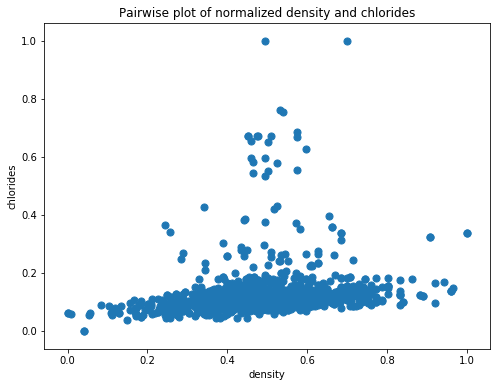

In [11]:
plot_density_chlorides(normalized_data)

Hmm the outliers above might form a cluster. Let's try running 10 iterations of K-means with $K=2$ and see how it goes!

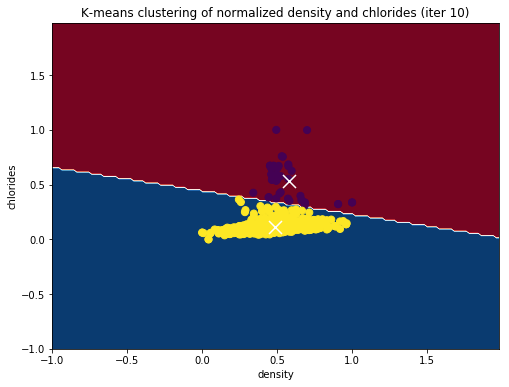

In [12]:
plot_kmeans_density_chlorides(normalized_data, random_state=3, k=2)

Eureka! We clustered the small group of wine samples. Although, I admit that we were lucky. If you change the `random_seed` to other values, there is a high chance that the cluster centers will be on the ellipse below. Such as this example:

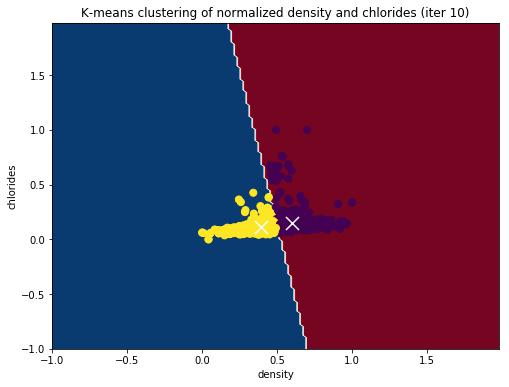

In [13]:
plot_kmeans_density_chlorides(normalized_data, random_state=20, k=2)

Argh! Do you see how much the centroid initialization impacts the outcome? This is why K-means is usually ran multiple times with randomly initialized centroids!

Feel free to play with `random_state` and `k`!

### Choosing K

The algorithm described above finds the clusters and data set labels for a particular $K$. To find the number of clusters in the data, we need to run the K-means clustering algorithm for a range of $K$ values and compare the results. In general, there is no method for determining the exact value of $K$, but an accurate estimate can be obtained using the following techniques.

One of the most used metrics to compare results across different values of $K$ is the mean distance between data observations and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing $K$ will always decrease this metric, to the extreme of reaching zero when $K$ is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of $K$ is plotted and the "elbow point", where the rate of decrease sharply shifts, can be used to roughly determine $K$.

As the wine dataset does not have clear clusters to visualize the, consider this toy dataset.

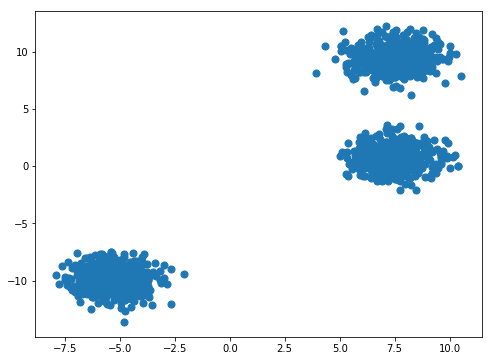

In [14]:
toy_data = plot_toy_dataset()

We can see that it clearly forms three different groups. Let's obtain and plot the average within cluster distance to the centroids for different $K$. 

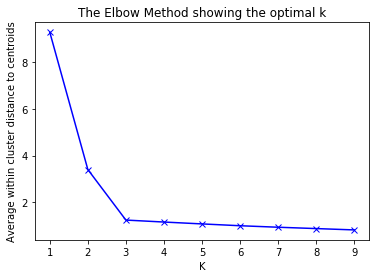

In [15]:
plot_elbow_method(toy_data)

We can clearly see that the rate of decrease sharply shifts when $K=3$, which matches the number of clusters we saw from the plot above! Let's now observe the K-means algorithm on the toy dataset for $K=3$.

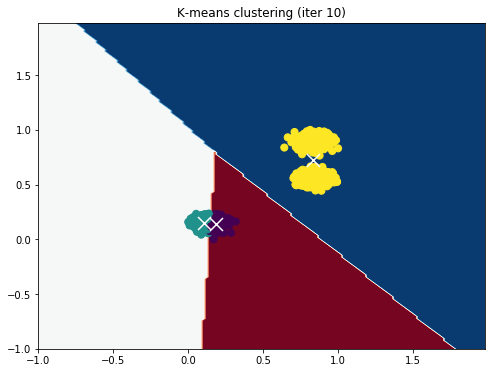

In [16]:
plot_kmeans(toy_data, random_state=123)

Uhoh, did you see what just happened? This was not supposed to happen! Two of the centroids were initialized on the cluster below, which resulted in an incorrect clustering. Let's do it again for a different `random_state`.

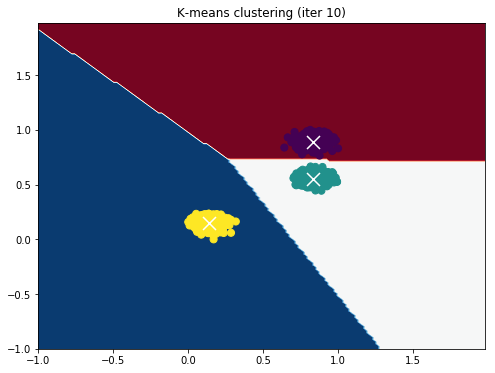

In [17]:
plot_kmeans(toy_data, random_state=100)

Much better! This is why most K-means implementations allow you to run the algorithm multiple times and return the best output of them all.

### More on choosing K

Sometimes, the elbow method is not very clear and it returns a "smooth elbow" which makes it hard to find a suitable $K$. Luckily, there are some metrics that you can use to evaluate your clusters. In order to not make this notebook very dense, I will list a few for you to explore!

* Silhouette Coefficient: http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
* Calinski-Harabaz Index: http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index
* Davies Bouldin Index: https://github.com/akankshadara/Davies_Bouldin_Index_KMeans

### Scikit Learn Implementation

Luckily you have the K-means algorithm already implemented on scikit learn. You only have to import it:

In [18]:
from sklearn.cluster import KMeans

The default parameters of K-means are:

Init signature: KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')

And then you can use the methods that you are already used to, such as `fit` and `predict`. Pretty simple!

In [19]:
kmeans = KMeans()
kmeans.fit(data)
print(kmeans.predict(data))

[6 2 4 ... 4 4 4]


# Dimensionality Reduction

Dealing with a lot of dimensions can be painful for machine learning algorithms. High dimensionality will increase the computational complexity, increase the risk of overfitting (as your algorithm has more degrees of freedom) and the sparsity of the data will grow. Hence, dimensionality reduction will project the data in a space with less dimension to limit these phenomena.

### Why Dimensionality Reduction?

Dimensionality reduction has two main advantages from a machine learning point of view:

1. Since our model has fewer degrees of freedom, the likelihood of overfitting is lower. The model will generalize more easily to new data.
2. Most Feature Extraction techniques are unsupervised. They don't need a target variable. This can be really helpful if you have a lot of unlabeled data (for instance text or images) and labeling is time-consuming and expensive.

### Feature Selection vs Feature Extraction

While feature selection is efficient, it is brutal since variables are either kept or removed. However, in some cases, a removed feature may be useful while a kept feature may be redundant. Feature extraction solves that issue by keeping only the intervals of the features which contain predictive information.

One of the most popular Feature Extraction algorithms is the Principal Component Analysis (PCA). We will go through a brief overview of what it is and how we can use it.

### Principal Component Analysis

As we have a dataset of wine samples, then it is best to introduce PCA this way.

We can describe each wine by its color, by how strong it is, by how old it is, and so on. We can compose a whole list of different characteristics of each wine in our cellar. But many of them will measure related properties and so will be redundant. If so, we should be able to summarize each wine with fewer characteristics! This is basically what PCA does. 

PCA does not select some characteristics and discard the others. Instead, it constructs some new characteristics that turn out to summarize our list of wines well. Of course these new characteristics are constructed using the old ones; for example, a new characteristic might be computed as wine age minus wine acidity level or some other combination like that (we call them linear combinations).

In fact, PCA finds the best possible characteristics, the ones that summarize the list of wines as well as only possible (among all conceivable linear combinations). This is why it is so useful.

In a slightly more technical way, PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance (the "amount of information" contained in the data). We can see each component as a dimension, thus the larger the number of components, the more information it will contain.

**Note:** In order to correctly perform PCA, we must standardize our data, because PCA expects that each feature in our data has a mean of zero and a standard deviation of one. The formula for standardizing data is the following:

$$x = \frac{x - \bar{x}}{\sigma}$$

where $\bar{x}$ is the feature mean and $\sigma$ is its standard deviation. We can do this with the `StandardScaler` object from scikit learn.

In [20]:
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler().fit(data)
standardized_data = sclr.fit_transform(data)

When applying PCA, one of the most important decisions is choosing the number of principal components (dimensions) to keep. The first components will contain most of the variance (again, the "amount of information" contained in the data), while the last ones will contain the least. What is usually done, is to cumulatively sum the amount of variance explained by each component from the most important to the least important. Note that this sum will have a maximum of 1, which is the original variance.

The plot can be obtained through this function below:

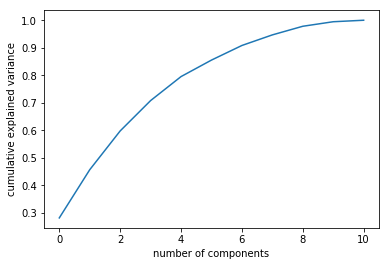

In [21]:
plot_cumulative_explained_variance_ratio(standardized_data)

We can see that the curve tends to stabilize as we increase the number of principal components. If our goal was to reduce the number of dimensions and keeping most of the information, we would want to keep the cumulative explained variance above 0.9, perhaps 0.95. Thus, we could use only 8 out of the 11 principal components and keep 95% of the cumulative explained variance. This way we reduced our data dimensionality by three dimensions.

### Use case: Classification

Before we start, I wanted to add that dimensionality reduction can also be used to aid regression, and not only classification.

Let's change our focus from a purely unsupervised data exploration point of view, to how dimensionality reduction can aid us in a classification problem. 

PCA also can help us to visualize our data. Especially for classification tasks where we can color each data observation with a specific label. And we can do this for our wine dataset?

>_But we do not have any labels, remember?_

Well, I lied to you, we do have another feature that we *could* consider as labels, which is the wine quality.

<img src="https://m.popkey.co/18fc00/O9ebk.gif" style="width: 400px;"/>

There, there, let's get the wine quality.

In [22]:
wine_quality = get_wine_quality()

For now, we will only use this feature to color the wine samples after applying PCA. Imagine that before applying a classification model, we wanted to have a quick data visualization in two dimensions. 

Luckily, PCA is already implemented in scikit learn and we can apply it to out standardized data as follows:

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(standardized_data)
reduced_data = pca.transform(standardized_data)
reduced_data = pd.DataFrame(reduced_data, columns = ["first_component", "second_component"])

**NOTE:** Once the data is reduced, you cannot obtain the original data by doing 
```python
reconstructed_data = pca.inverse_transform(reduced_data)
```
as you already lost part of the original information while reducing the data's dimensions! So, it is advised to copy the data before applying PCA to it.

Let's just verify the shape of the transformed data.

In [24]:
reduced_data.shape

(1599, 2)

Success! We reduced our data to only two dimensions! Neat!

Let's now visualize it and see if it makes any visual sense.

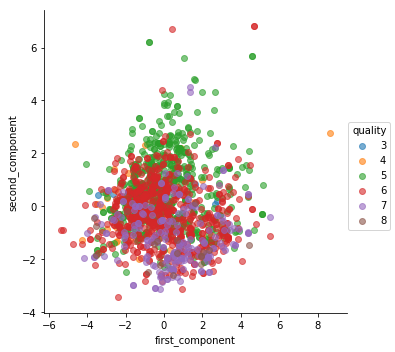

In [25]:
plot_two_dimensions(reduced_data, wine_quality)

It is not a work of art, but we can see that wines with a quality of 5 seem to be the most distinguishable ones!

**Let's now tackle this problem as a classification task.** We will do the usual train test split with our standardized data.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(standardized_data, wine_quality, test_size=0.33, random_state=0)

And now let's just apply apply a Random Forest Classifier and obtain the test accuracy.

In [27]:
# Choose the model
random_forest = RandomForestClassifier(n_estimators=200, random_state=0)

# Fit the model
random_forest = random_forest.fit(X_train, y_train)

# Score the predictions
score = random_forest.score(X_test, y_test)

print("Accuracy with original dataset: %f" % score)

Accuracy with original dataset: 0.679924


Now, let's reduce our data with PCA! We saw previously in the cumulative variance explained ratio plot, that we could reduce our dataset to 8 dimensions while keeping 95% of the total variance. So let's do just that.

In [28]:
pca = PCA(n_components=8, random_state=0).fit(standardized_data)
reduced_data = pca.transform(standardized_data)

Now let's do the train test split with the same `random_state` as before.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, wine_quality, test_size=0.33, random_state=0)

Finally, let's train a Random Forest Classifier in our reduced dataset.

In [30]:
# Choose the model
random_forest = RandomForestClassifier(n_estimators=200, random_state=0)

# Fit the model
random_forest = random_forest.fit(X_train, y_train)

# Score the predictions
score = random_forest.score(X_test, y_test)

print("Accuracy with reduced dataset: %f" % score)

Accuracy with reduced dataset: 0.689394


Whoa, our reduced dataset actually led to a better performing model! This is because the model overfitted less on the data and generalized better.

Congratulations on applying and plotting your first PCA transformations as well as applying them on a classification task! 

Scikit learn also has other dimensionality reduction techniques. The two most popular ones are the following:
* Latent Dirichlet Allocation (LDA): http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation
* t-distributed Stochastic Neighbour Embedding (t-SNE): http://scikit-learn.org/stable/modules/manifold.html#t-sne